In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random 
#switching off scientific notation
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(suppress=True)

In [3]:
df = pd.read_csv('Sweden Load Data 2005-2017.csv')
df.rename({'cet_cest_timestamp':'time', 'SE_load_actual_tso':'load'},
          axis='columns', 
          inplace=True)
df['time'] = pd.to_datetime(df['time'],errors='ignore', utc=True)
df['weekday'] = df['time'].dt.weekday

In [4]:
df.head(2)

,time,load,weekday
0,2005-01-01 00:00:00+00:00,15991.34,5
1,2005-01-01 01:00:00+00:00,15673.12,5


In [7]:
# Discharges the batteries. We consume less energy that we would 
# normally do.  
def discharge(agent, timestamp, load):
    discharge_amount = min(load, agent.battery_charge_speed, agent.battery_level)
    agent.battery_level -= discharge_amount
    agent.history.append((timestamp, load - discharge_amount, 'discharge'))

# Charges the batteries. Meaning, the system consumption increases
# by the battery charging speed. 
def charge(agent, timestamp, load):
    charge_amount = min(agent.battery_charge_speed, agent.battery_max - agent.battery_level)
    agent.battery_level += charge_amount
    agent.history.append((timestamp, load + charge_amount, 'charge'))

# Does nothing. The real consumption is the same as original one. 
def wait(agent, timestamp, load):
    agent.history.append((timestamp, load, 'wait'))

ACTION_SPACE = (discharge, charge, wait)

# The policy#1 to compare with. Take the random choice of available ones.
def random_policy(agent, _timestamp, _load):
    return(random.choice(agent.available_actions()))

class Agent2:    
    #class constructor function
    def __init__(self, 
                 battery_level=0,
                 battery_max=400,
                 battery_charge_speed = 100,
                 loads = np.array([]),
                 action_space=ACTION_SPACE, 
                 policy=random_policy,
                 action=wait):
        self.battery_max = battery_max
        self.battery_charge_speed = battery_charge_speed
        self.array_loads = loads
        self.battery_level = battery_level
        self.collection_loads = []
        self.collection_rewards = []
        self.action_space = action_space
        self.action = action
        self.policy = policy
        self.history = []

    # Applies the action chozen at the previous timestamp to the
    # current time and load data. For example, if 1 hour ago we choose to 
    # charge the battery, now we need to increase the default concumption
    # by that value. Then, write it to the alternative history.
    # Afteer saving history, it also chooses action for the next 1 hour. 
    def tick(self, timestamp, load):
        self.action(self, timestamp, load)
        self.action = self.policy(self, timestamp, load)

    # Returns the list of available actions at the current time.abs 
    # For example, if the battery is fully charged, it returns 'wait'
    # and 'discharge', since 'charge' is not allowed. 
    # 'Wait' is always available
    def available_actions(self):
        result = [wait]
        if self.battery_level > 0: result.append(discharge)
        if self.battery_level < self.battery_max: result.append(charge)
        return result

In [10]:
test_df = df.head(50).copy()
agent4 = Agent2(loads = test_df)
for i, row in test_df.iterrows():
    agent4.tick(row['time'], row['load'])
actual_history = pd.DataFrame(agent4.history, columns= ['time', 'load', 'past_action'])

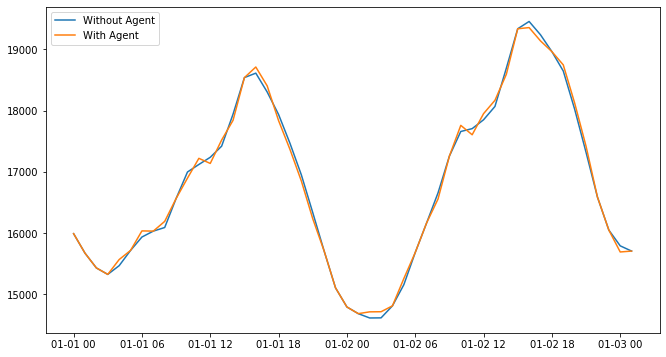

In [16]:
agent4 = Agent2(loads = test_df, 
                 battery_max=400,
                 battery_charge_speed = 100,)
for i, row in test_df.iterrows():
    agent4.tick(row['time'], row['load'])
    
actual_history = pd.DataFrame(agent4.history, columns= ['time', 'load', 'past_action'])

plt.figure(figsize=(11,6))
plt.plot(test_df.time.values,test_df.load.values)
plt.plot(test_df.time.values, actual_history.load)
plt.legend(['Without Agent','With Agent'])
plt.show()

In [18]:
def cost(load):
    return np.sum(5 + 0.5 * load + 0.05 * load ** 2)

print("Total cost without agent:", cost(test_df.load.values))
print("Total cost with random agent:", cost(actual_history.load.values))

Total cost without agent: 709748296.9664352
Total cost with random agent: 710187980.066435


In [19]:
def rule_policy(agent, timestamp, load, min_baseline=15500, max_baseline=18000):
    if load < min_baseline and (charge in agent.available_actions()): return charge 
    if load > max_baseline and (discharge in agent.available_actions()): return discharge
    return wait

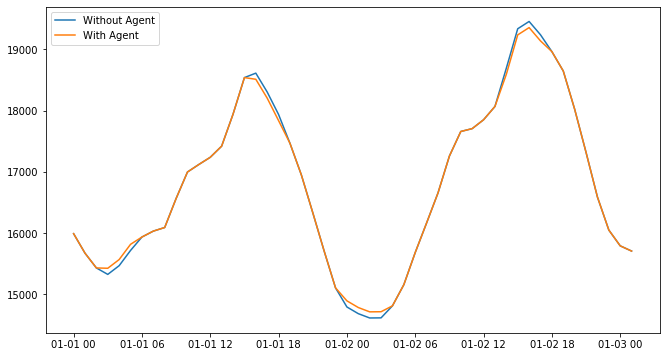

Total cost without agent: 709748296.9664352
Total cost with random agent: 709491913.366435


In [22]:
agent5 = Agent2(loads = test_df, 
                 battery_max=400,
                 battery_charge_speed = 100,
                 policy=rule_policy)

for i, row in test_df.iterrows():
    agent5.tick(row['time'], row['load'])
    
actual_history = pd.DataFrame(agent5.history, columns= ['time', 'load', 'past_action'])

plt.figure(figsize=(11,6))
plt.plot(test_df.time.values,test_df.load.values)
plt.plot(test_df.time.values, actual_history.load)
plt.legend(['Without Agent','With Agent'])
plt.show()

print("Total cost without agent:", cost(test_df.load.values))
print("Total cost with random agent:", cost(actual_history.load.values))